Note that steps 1 and 2 of this strategy were executed in terminal. This notebook continues from steps 3-5.

# Setup

In [1]:
%reload_ext autoreload

# Imports
from os.path import join

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Constants
BASELINE_PATH = join('data', 'baseline_coverage.txt')
MODIFIED_PATH = join('data', 'modified_coverage.txt')
COLUMNS = ['chromosome', 'position', 'depth']

# Preliminaries
First, I open the coverage files generated in step 2.

In [2]:
baseline_coverage = pd.read_csv(BASELINE_PATH, sep='\t', header=None, names=COLUMNS)
modified_coverage = pd.read_csv(MODIFIED_PATH, sep='\t', header=None, names=COLUMNS)

At this point, it's worth visualising the coverage distributions to see better understand them. Doing so will also give us clues on how to normalise them.

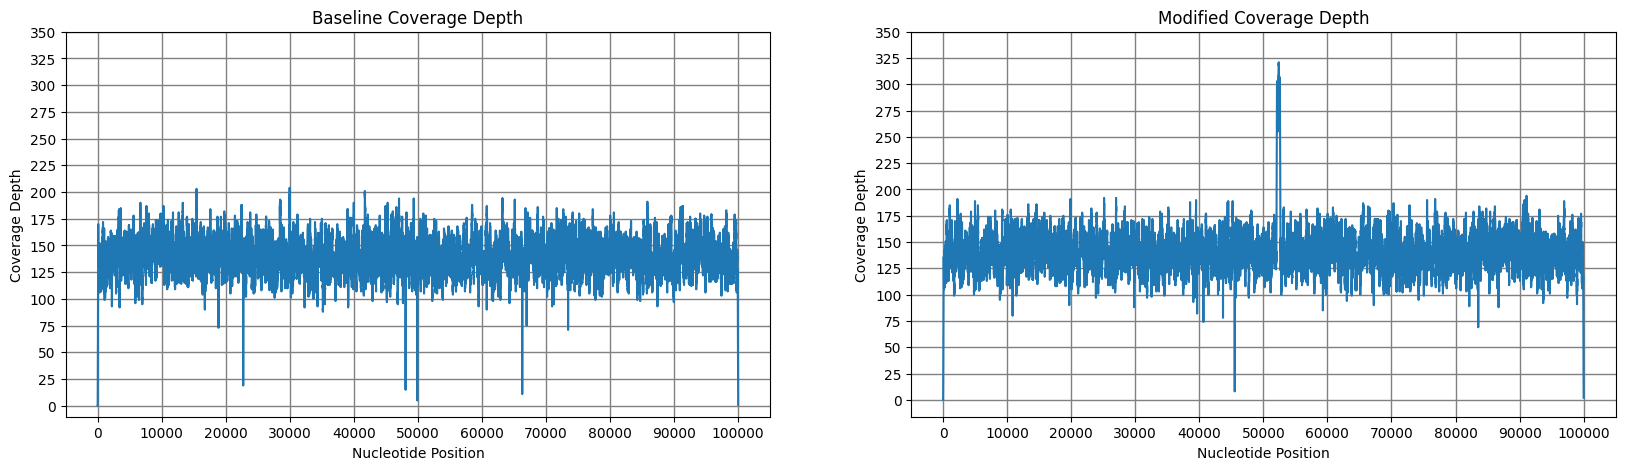

In [3]:
fig = plt.figure(figsize=(20, 5))
xticks = np.arange(0, len(baseline_coverage)+1, 10000)
yticks = np.arange(0, 370, 25)

ax0 = fig.add_subplot(1,2,1)
plt.plot(baseline_coverage['depth'])
ax0.set_title("Baseline Coverage Depth")
ax0.set_yticks(yticks)
ax0.set_xticks(xticks)
ax0.grid(color='gray', linestyle='-', linewidth=1)
ax0.set_xlabel('Nucleotide Position')
ax0.set_ylabel('Coverage Depth')

ax1 = fig.add_subplot(1,2,2)
plt.plot(modified_coverage['depth'])
ax1.set_title("Modified Coverage Depth")
ax1.set_yticks(yticks)
ax1.set_xticks(xticks)
ax1.set_xlabel('Nucleotide Position')
ax1.set_ylabel('Coverage Depth')
ax1.grid(color='gray', linestyle='-', linewidth=1)

plt.show()

Both figures are approximately uniformly distributed, which suggests that a simple mean normalization is sensible for this application. There are also some outliers in both distributions with considerably lower depths. We will filter them out at a later stage as computing the copy gain will further change the shape of the distributions. Looking at the modified coverage depth plot, there's a spike in coverage around the 50'000th position. In all likelihood, this is our region of interest for this task.

# Step 3: Normalize Coverage Distributions
Now we normalise the distributions so that we can compare them directly. We do so by dividing all values in each distribution by their respective means.

In [4]:
baseline_mean = baseline_coverage['depth'].mean()
modified_mean = modified_coverage['depth'].mean()

# Normalize by sample mean
baseline_coverage_norm = baseline_coverage['depth'] / baseline_mean
modified_coverage_norm = modified_coverage['depth'] / modified_mean

By visualising the normalized forms of the coverage distributions we can confirm if the choice of normalisation was reasonable.

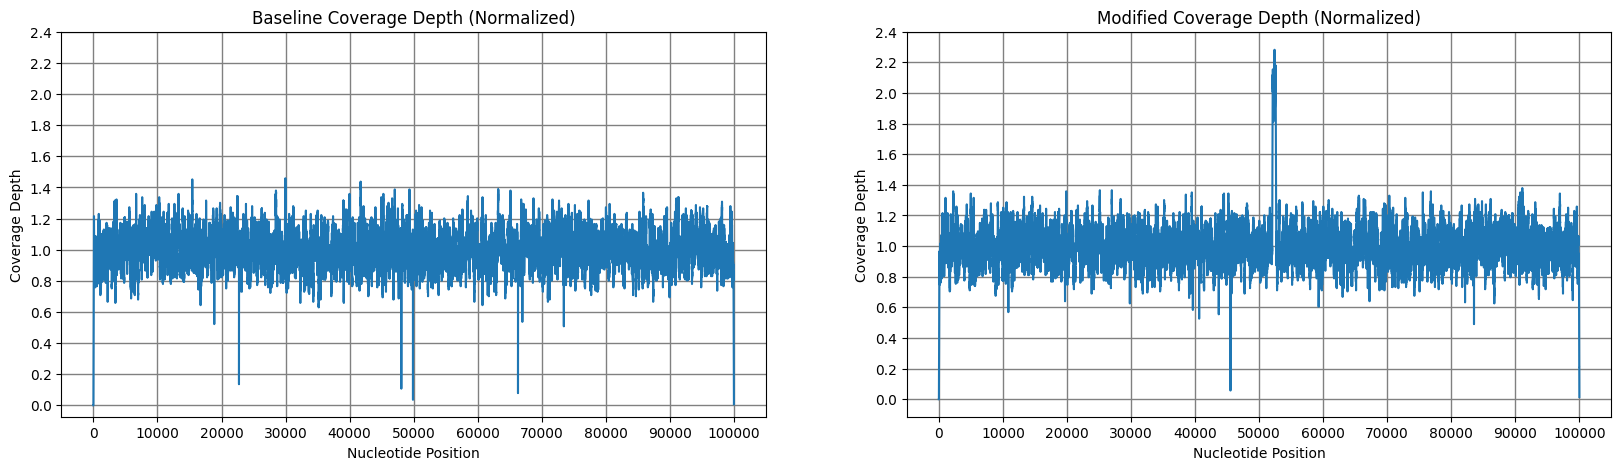

In [5]:
fig = plt.figure(figsize=(20, 5))
y_ticks = np.arange(0, 2.5, 0.2)
xticks = np.arange(0, len(baseline_coverage)+1, 10000)

ax0 = fig.add_subplot(1,2,1)
plt.plot(baseline_coverage_norm)
ax0.set_title("Baseline Coverage Depth (Normalized)")
ax0.set_yticks(y_ticks)
ax0.set_xticks(xticks)
ax0.grid(color='gray', linestyle='-', linewidth=1)
ax0.set_xlabel('Nucleotide Position')
ax0.set_ylabel('Coverage Depth')

ax1 = fig.add_subplot(1,2,2)
plt.plot(modified_coverage_norm)
ax1.set_title("Modified Coverage Depth (Normalized)")
ax1.set_yticks(y_ticks)
ax1.set_xticks(xticks)
ax1.set_xlabel('Nucleotide Position')
ax1.set_ylabel('Coverage Depth')
ax1.grid(color='gray', linestyle='-', linewidth=1)

The graphs have retained their general shape and their relative amplitudes are much lower, this will make comparisons much easier. The distributions are now ready to be compared elementwise.

# Step 4: Determine Copy Number Gain
Now that the distributions are normalized we can determine the copy number gain for each. The gain will be calculated as the elementwise difference between the query (modified) distribution and the baseline ditribution and expressed as a factor of the baseline. The formula is as follows:

$$Gain\ =\ \frac{Coverage_{mod} - Coverage_{base}}{Coverage_{base}}$$

In [6]:
copy_no_gain_dist = (modified_coverage_norm - baseline_coverage_norm) / baseline_coverage_norm

Now to visualize the gain.

[]

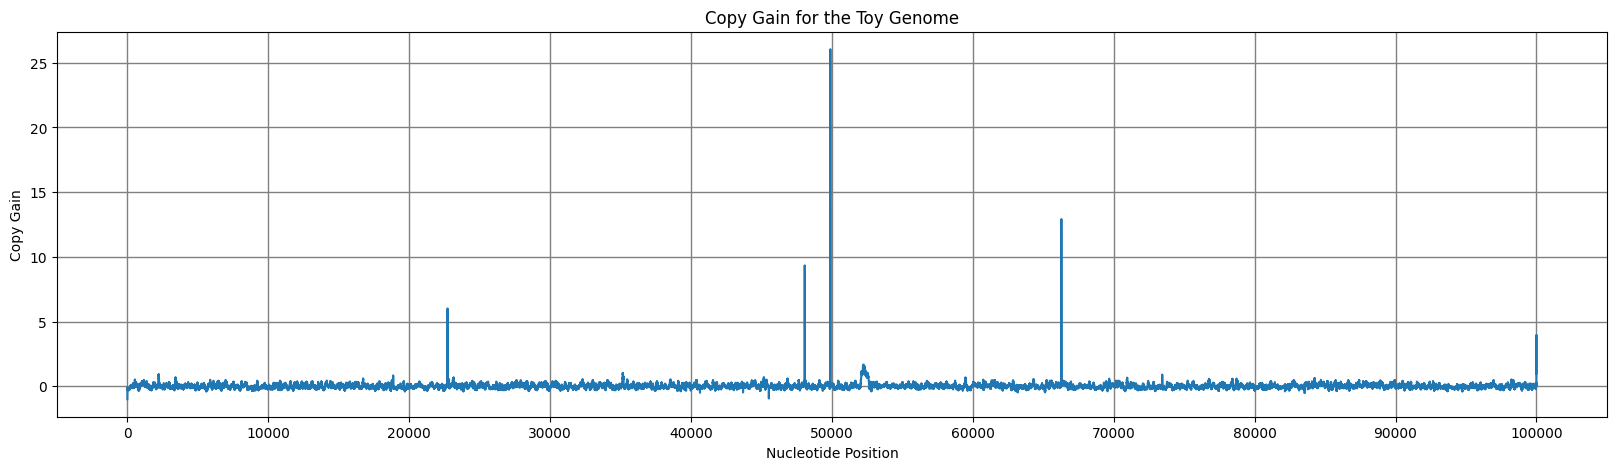

In [7]:
fig = plt.figure(figsize=(20, 5))
xticks = np.arange(0, len(baseline_coverage)+1, 10000)

plt.plot(copy_no_gain_dist)
plt.title("Copy Gain for the Toy Genome")
plt.grid(color='gray', linestyle='-', linewidth=1)
plt.xlabel('Nucleotide Position')
plt.xticks(xticks)
plt.ylabel('Copy Gain')
plt.plot()

The discontinuous spikes in the graph are the outliers previously mentioned. Now we can filter them out to get a clear picture. An easy way to achieve this is to set all values exceeding a 2.5 gain from the mean.

[]

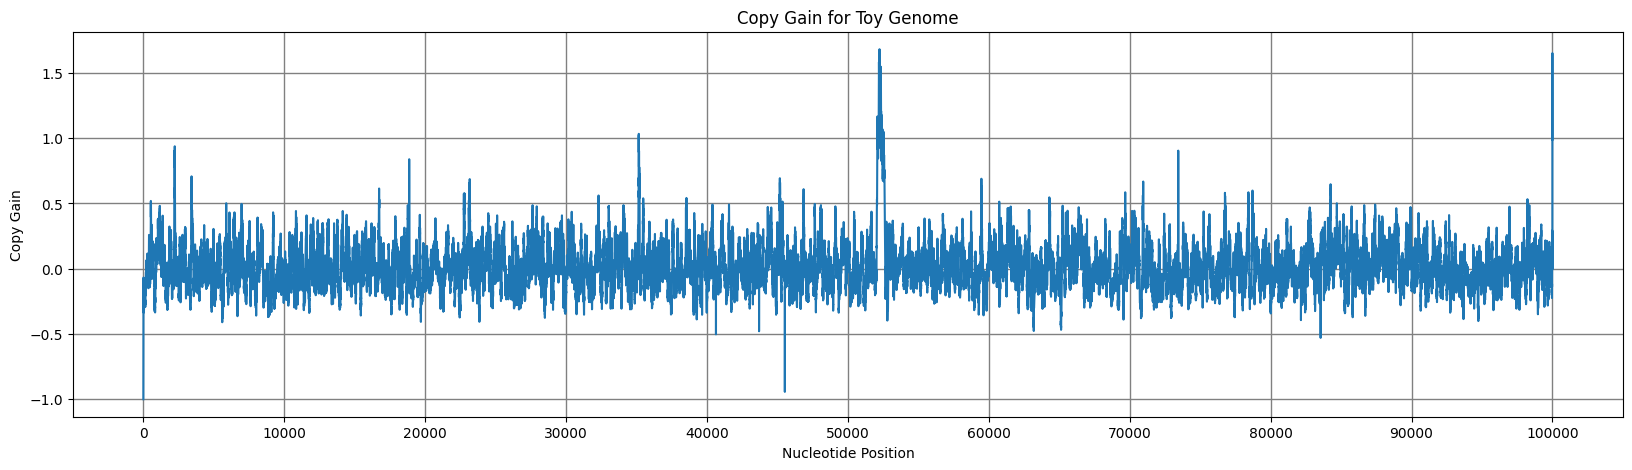

In [8]:
copy_no_gain_dist[copy_no_gain_dist > 2.5] = copy_no_gain_dist.mean()

fig = plt.figure(figsize=(20, 5))
xticks = np.arange(0, len(baseline_coverage)+1, 10000)

plt.plot(copy_no_gain_dist)
plt.title("Copy Gain for Toy Genome")
plt.grid(color='gray', linestyle='-', linewidth=1)
plt.xlabel('Nucleotide Position')
plt.xticks(xticks)
plt.ylabel('Copy Gain')
plt.plot()

Now, the picture is quiet clear. Our region of interest lies in the 50'000th neighborhood, as suspected.

# Step 5: Region Extraction and Gene Correlation.
We have many options for extracting the precise region of interest but the easiest would be to filter out all positions between positions 50'000-55'000 and gain 0.75-2.0.

In [19]:
roi = copy_no_gain_dist.loc[50000: 55000]
roi = roi[(roi <= 2.0) & (roi >= 0.75)]

print(roi)

52077    0.792823
52078    0.772735
52079    0.789691
52080    0.800237
52081    0.809128
           ...   
52577    0.777263
52578    0.753873
52579    0.795905
52589    0.750652
52593    0.757174
Name: depth, Length: 487, dtype: float64


If we take the endpoints of the ROI, `[52077, 52593]` and compare it to the annotations file (`toy_genome_genes.bed`) we see that the ROI aligns almost perfectly with gene_14:
`toy_genome	52100	52600	gene_14	0	+`. Furthermore, the ROI is 487 nucleotides long, which remarkably close to the length of any gene in this genome (all genes are 500 nucleotides long). Thus we conclude that the gene with a 2x copy gain is gene_14.